In [ ]:
# --- BLOCK 1: INSTALL DEPENDENCIES & FIX RUNTIME ---

import os
import shutil
from pathlib import Path

# 1. FIX: Mac GPU Error Fallback
# This prevents the specific "NotImplemented" crash on M1/M2/M3 chips
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
from fastai.vision.all import *

# 2. GLOBAL SETTING: Force everything to CPU
# This prevents the "RuntimeError: Found two devices" crash
defaults.device = torch.device('cpu')

print(f"✅ Setup Complete. Running on: {defaults.device}")

/Users/lucalangella1/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✅ Setup Complete. Running on: cpu


In [ ]:
# --- BLOCK 2: DOWNLOAD RANDOM IMAGES (Fix for empty folder) ---
import shutil
from fastai.vision.all import *
from pathlib import Path

# 1. Setup your destination
dest_folder = Path('./tennis_courts/unknown')
dest_folder.mkdir(exist_ok=True)

# 2. Download "Imagenette" (A tiny dataset of random objects)
print("Downloading random images...")
path_random = untar_data(URLs.IMAGENETTE_160)

# 3. Grab 50 random images and copy them
# We take them from the 'train' folder of the downloaded dataset
random_files = get_image_files(path_random/'train')[:50] 

print(f"Copying {len(random_files)} random images to 'unknown' folder...")
for i, file in enumerate(random_files):
    shutil.copy(file, dest_folder / f'random_{i}.jpg')

print("✅ DONE! The 'unknown' folder is now full. You can re-run the Training Block below.")

Copying 50 random images to 'unknown' folder...
✅ DONE! The 'unknown' folder is now full. You can re-run the Training Block below.


In [ ]:
# --- BLOCK 3: TRAIN 4-CLASS MODEL (Clay, Grass, Hard, Unknown) ---
import shutil
from fastai.vision.all import *
from pathlib import Path
import os

# 1. Setup path
path = Path('./tennis_courts')

# 2. Safety Check: Ensure unknown folder exists
unknown_folder = path/'unknown'
if not unknown_folder.exists() or len(get_image_files(unknown_folder)) == 0:
    print("⚠️ WARNING: The 'unknown' folder is empty! Run the download cell above first.")

# 3. Load Data (Now finding 4 classes)
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224, method='squish'),
    batch_tfms=aug_transforms(mult=1.5),
    bs=16,
    num_workers=0,
    device=torch.device('cpu') 
)

print(f"Classes found: {dls.vocab}") 
# VERIFY: Should be ['clay', 'grass', 'hard', 'unknown']

# 4. Train
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.model.to('cpu')
learn.dls.to('cpu')

print("Training 4-class model...")
learn.fine_tune(1)

Classes found: ['clay', 'grass', 'hard', 'unknown']
Training 4-class model...


epoch,train_loss,valid_loss,error_rate,time
0,2.151419,0.585986,0.193548,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.906624,0.163537,0.032258,00:11


Displaying predictions (Green = Correct, Red = Mistake)


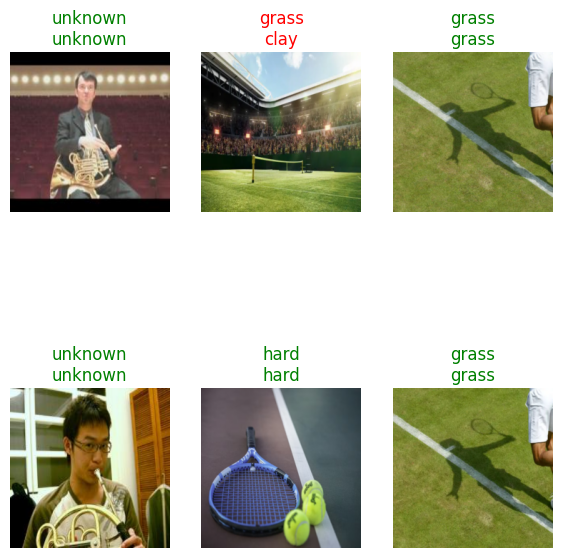

In [ ]:
# --- BLOCK 4: PREDICTION VISUALIZATION ---
# Display sample predictions from the validation set
# Format: Label = Actual Class / Prediction = Model Output
print("Displaying predictions (Green = Correct, Red = Mistake)")
learn.show_results(max_n=6, figsize=(7, 8))

Confusion Matrix:



Top 5 Worst Mistakes (Images):


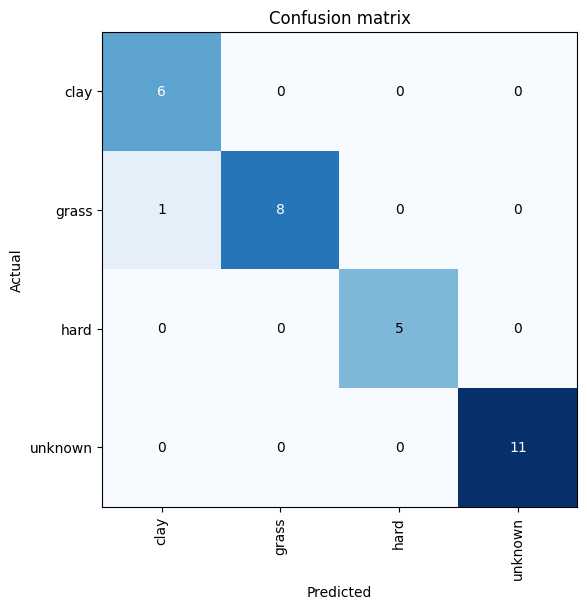

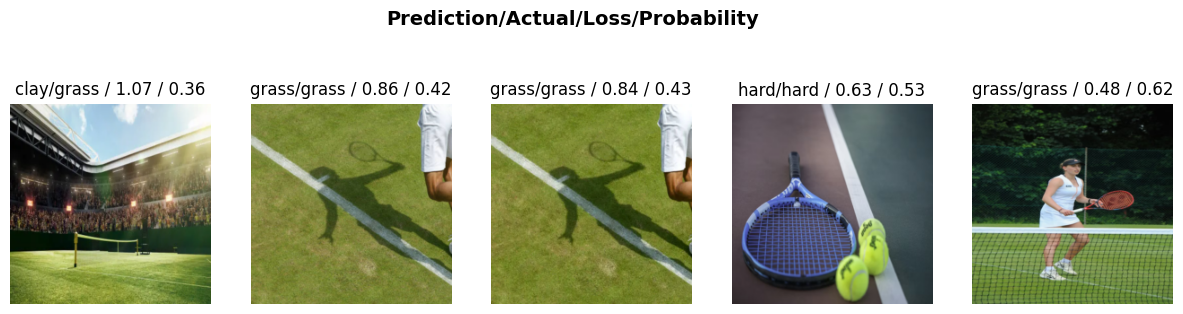

In [ ]:
# --- BLOCK 5: ERROR ANALYSIS ---
# 1. Create the interpreter
interp = ClassificationInterpretation.from_learner(learn)

# 2. Plot the Confusion Matrix (The Grid)
print("Confusion Matrix:")
interp.plot_confusion_matrix(figsize=(6, 6))

# 3. Plot the Top Losses (The Images)
# This shows the specific photos that confused the AI the most.
# Format: Top Label = Truth / Bottom Label = Prediction
print("\nTop 5 Worst Mistakes (Images):")
interp.plot_top_losses(5, nrows=1, figsize=(15, 4))

In [ ]:
# ---BLOCK 6: INTERACTIVE TEST ---
import ipywidgets as widgets
from PIL import Image
import io

# 1. Create the upload button
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

def on_data_change(change):
    lbl_pred.value = ''

    # Get the uploaded image
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))

    # Predict
    pred, pred_idx, probs = learn.predict(img)

    # Show result
    lbl_pred.value = f'PREDICTION: {pred.upper()} (Confidence: {probs[pred_idx]*100:.2f}%)'

# Link the button to the function
btn_upload.observe(on_data_change, names=['data'])

# Display the widget
print("Click 'Upload' to test a new image:")
display(widgets.VBox([btn_upload, out_pl, lbl_pred]))

Click 'Upload' to test a new image:


In [ ]:
# --- BLOCK 7: COREML EXPORT ---
import coremltools as ct
import torch

# 1. Get the trained model (ensure it is on CPU)
model = learn.model.eval().cpu()

# 2. Create dummy input (1 image, 3 channels, 224x224 pixels)
# This tells the converter what size image the iPhone will send to the AI
dummy_input = torch.rand(1, 3, 224, 224)

# 3. Trace the model
print("Tracing model...")
traced_model = torch.jit.trace(model, dummy_input)

# 4. Convert to Core ML format
print("Converting to Core ML...")
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(
        name="image", 
        shape=dummy_input.shape, 
        scale=1/255.0, # Convert 0-255 RGB values to 0-1
        bias=[-0.485/0.229, -0.456/0.224, -0.406/0.225] # Normalize colors for ResNet
    )],
    classifier_config=ct.ClassifierConfig(list(dls.vocab)) # Save the class names (hard, clay, grass)
)

# 5. Add Metadata and Save
mlmodel.short_description = "Classifies Tennis Court Surfaces"
mlmodel.author = "Luca"
mlmodel.save("TennisClassifier.mlpackage")

print("\n✅ SUCCESS! 'TennisClassifier.mlpackage' is saved in your project folder.")

Tracing model...


When both 'convert_to' and 'minimum_deployment_target' not specified, 'convert_to' is set to "mlprogram" and 'minimum_deployment_target' is set to ct.target.iOS15 (which is same as ct.target.macOS12). Note: the model will not run on systems older than iOS15/macOS12/watchOS8/tvOS15. In order to make your model run on older system, please set the 'minimum_deployment_target' to iOS14/iOS13. Details please see the link: https://apple.github.io/coremltools/docs-guides/source/target-conversion-formats.html


Converting to Core ML...


Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 438.02 passes/s]



✅ SUCCESS! 'TennisClassifier.mlpackage' is saved in your project folder.
